In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster 
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
df = pd.read_csv(r'/workspaces/Nursing-Home-Analysis/2021_CostReport_Clean.csv')

In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15057 entries, 0 to 15056
Data columns (total 80 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   rpt_rec_num                                                       15057 non-null  int64  
 1   Provider CCN                                                      15057 non-null  int64  
 2   Facility Name                                                     15057 non-null  object 
 3   Street Address                                                    15057 non-null  object 
 4   City                                                              15057 non-null  object 
 5   State Code                                                        15057 non-null  object 
 6   Zip Code                                                          15057 non-null  object 
 7   County                         

In [6]:
print(df['Less Total Operating Expense'].mean())
print(df['Net Patient Revenue'].mean())

10386540.925815236
9201937.407982998


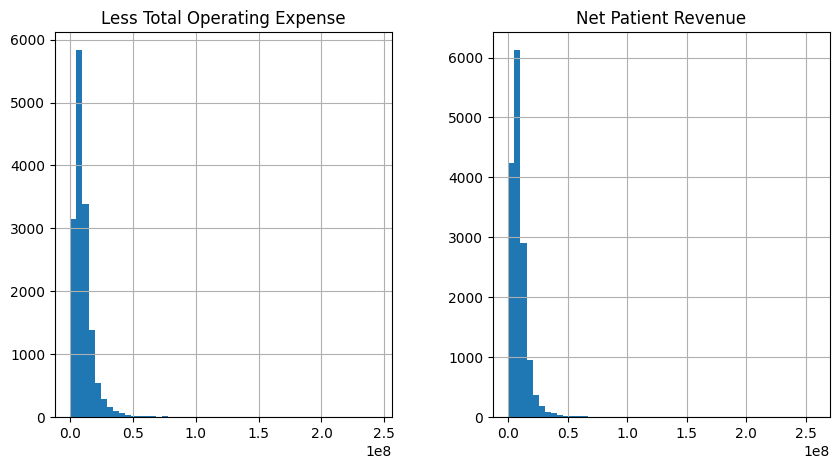

In [7]:
df[['Less Total Operating Expense', 'Net Patient Revenue']].hist(bins=50, figsize=(10,5))
plt.show() #before removing outliers

In [8]:
Q1 = df['Less Total Operating Expense'].quantile(0.25)
Q3 = df['Less Total Operating Expense'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['Less Total Operating Expense'] >= lower_bound) & (df['Less Total Operating Expense'] <= upper_bound)]

Q1_npr = df['Net Patient Revenue'].quantile(0.25)
Q3_npr = df['Net Patient Revenue'].quantile(0.75)
IQR_npr = Q3_npr - Q1_npr

lower_bound_npr = Q1_npr - 1.5 * IQR_npr
upper_bound_npr = Q3_npr + 1.5 * IQR_npr

df = df[(df['Net Patient Revenue'] >= lower_bound_npr) & (df['Net Patient Revenue'] <= upper_bound_npr)]

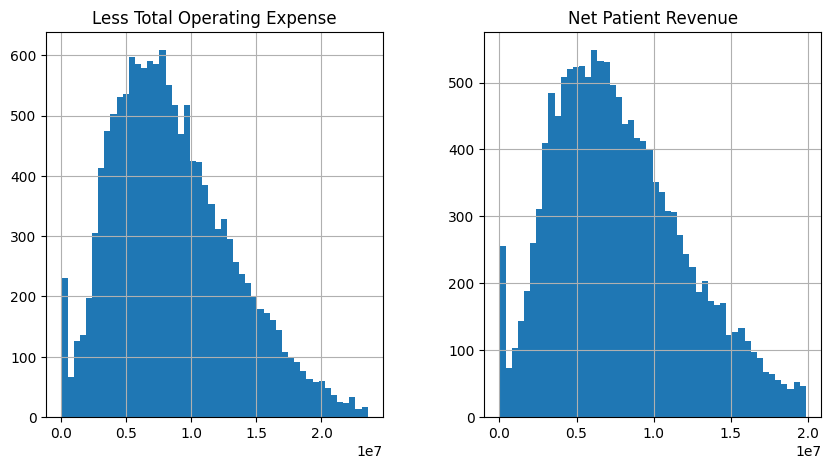

In [9]:
df[['Less Total Operating Expense', 'Net Patient Revenue']].hist(bins=50, figsize=(10,5))
plt.show() #after removing outliers

In [10]:
df['ROI'] = (df['Net Patient Revenue'] - df['Less Total Operating Expense']) / df['Less Total Operating Expense'] * 100

df = df[df['ROI'] >= 0]

df['ROI_Target'] = df['ROI'] > df['ROI'].quantile(0.70)

label_dict = {True: 1, False: 0}

df['ROI_Target'] = df['ROI_Target'].map(label_dict)

In [11]:
df['ROI']

0        12.244700
3         8.151023
5        12.059095
8        49.555393
12       14.106034
           ...    
15038    29.776745
15044     6.433301
15047     0.952125
15054    22.856293
15056     4.770857
Name: ROI, Length: 3710, dtype: float64

In [12]:
new_df = df.select_dtypes(include=None, exclude=['object'])
new_df.isnull().mean()*100
new_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3710 entries, 0 to 15056
Data columns (total 73 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   rpt_rec_num                                                       3710 non-null   int64  
 1   Provider CCN                                                      3710 non-null   int64  
 2   Medicare CBSA Number                                              3710 non-null   float64
 3   Type of Control                                                   3710 non-null   float64
 4   Total Days Title XVIII                                            3710 non-null   float64
 5   Total Days Title XIX                                              3710 non-null   float64
 6   Total Days Other                                                  3710 non-null   float64
 7   Total Days Total                     

In [13]:
X = new_df.drop(['Less Total Operating Expense', 'Net Patient Revenue', 'ROI', 'ROI_Target'], axis=1)
y = new_df['ROI_Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [14]:
rf_grid = {'max_depth': [2,3,4,5,6],
           'min_samples_leaf': [0.015, 0.02, 0.025, 0.03, 0.035, 0.05],
           'n_estimators': [10, 50, 60, 100]}

rf = GridSearchCV(RandomForestClassifier(), param_grid=rf_grid, cv=5, n_jobs=-1)
rf.fit(X_train, y_train)
print("Train Score", rf.score(X_train, y_train))
print("Test Score", rf.score(X_test, y_test))
print("Best Parameters", rf.best_params_)
print("Features", rf.best_estimator_.feature_importances_)


Train Score 0.9235175202156334
Test Score 0.9070080862533693
Best Parameters {'max_depth': 6, 'min_samples_leaf': 0.015, 'n_estimators': 100}
Features [2.67790517e-03 7.99433003e-03 3.42773629e-03 3.18909472e-03
 1.41863136e-03 1.68614281e-03 5.17735844e-03 8.72147276e-03
 1.92201927e-03 4.48983168e-03 1.37364718e-03 7.16154272e-04
 1.35032835e-03 1.12936758e-03 1.08794625e-03 5.50460999e-04
 1.10811572e-03 6.59903558e-04 2.53776487e-04 2.25341533e-03
 1.29111134e-03 1.99712147e-03 2.45778240e-03 5.63382305e-03
 5.68544639e-03 2.43554358e-03 5.41496202e-03 3.96740220e-04
 1.28138064e-03 2.71895776e-03 2.52832122e-03 1.34384070e-02
 2.40758421e-02 2.07591970e-03 4.39239322e-03 1.21344933e-02
 1.35952769e-02 5.71003219e-03 4.06030598e-03 2.69091618e-03
 1.60721937e-03 1.71916380e-03 6.43050147e-03 1.56803310e-03
 1.55452501e-03 3.28288958e-03 7.23613684e-04 2.32798848e-03
 1.05862557e-02 4.10564927e-03 2.12030569e-03 2.08007609e-03
 1.64938746e-03 1.68480145e-03 5.50200698e-04 1.77381668

In [15]:
feature_names = X.columns
feature_importances = rf.best_estimator_.feature_importances_

for feature, importance in zip(feature_names, feature_importances):
    print(f"{feature}: {importance}")

rpt_rec_num: 0.0026779051745109005
Provider CCN: 0.007994330028049184
Medicare CBSA Number: 0.003427736294010378
Type of Control: 0.0031890947185140676
Total Days Title XVIII: 0.0014186313587158106
Total Days Title XIX: 0.0016861428096591321
Total Days Other: 0.005177358441408241
Total Days Total: 0.008721472759065157
Number of Beds: 0.001922019267597987
Total Bed Days Available: 0.0044898316848865395
Total Discharges Title XVIII: 0.0013736471820005743
Total Discharges Title XIX: 0.0007161542720229585
Total Discharges Title Other: 0.0013503283540792603
Total Discharges Total: 0.001129367579432798
SNF Average Length of Stay Title XVIII: 0.001087946251599387
SNF Average Length of Stay Title XIX: 0.0005504609989335168
SNF Average Length of Stay Total: 0.0011081157231981982
SNF Admissions Title XVIII: 0.0006599035575217009
SNF Admissions Title XIX: 0.0002537764866989191
SNF Admissions Other: 0.0022534153339859053
SNF Admissions Total: 0.0012911113365573234
SNF Days Title XVIII: 0.001997121

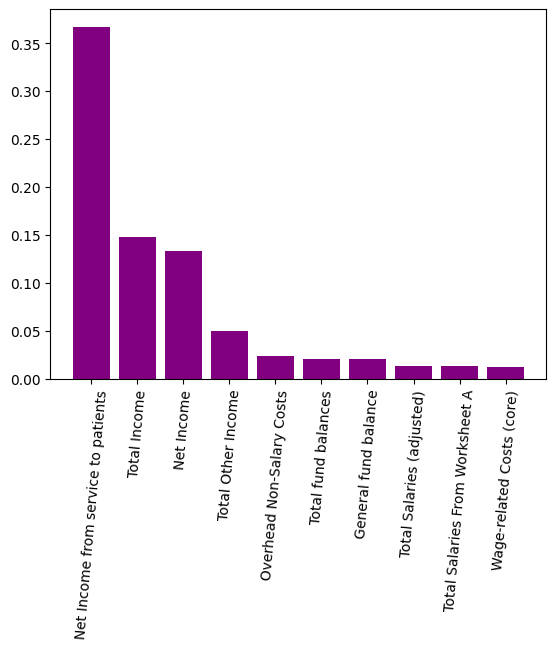

In [16]:
f_importances = pd.Series(rf.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
plt.bar(f_importances.index, height=f_importances, color='purple')
plt.xticks(rotation=85)
plt.show()

In [35]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3710 entries, 0 to 15056
Data columns (total 84 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   rpt_rec_num                                                       3710 non-null   int64  
 1   Provider CCN                                                      3710 non-null   int64  
 2   Facility Name                                                     3710 non-null   object 
 3   Street Address                                                    3710 non-null   object 
 4   City                                                              3710 non-null   object 
 5   State Code                                                        3710 non-null   object 
 6   Zip Code                                                          3710 non-null   object 
 7   County                               

In [39]:
relevant_columns = ['Net Patient Revenue', 'Less Total Operating Expense', 'Net Income from service to patients', 'Allowable Bad Debts', 'Inpatient PPS Amount']
weights = {'Net Patient Revenue': 0.3, 'Less Total Operating Expense': 0.2, 'Net Income from service to patients': 0.2, 'Allowable Bad Debts': 0.2, 'Inpatient PPS Amount': 0.1}

weighted_sum = np.sum(df[relevant_columns] * np.array(list(weights.values())), axis=1)
df['Risk Score'] = weighted_sum


In [40]:
new_df = df[['Risk Score', 'ROI_Target', 'State Code Encoded']]


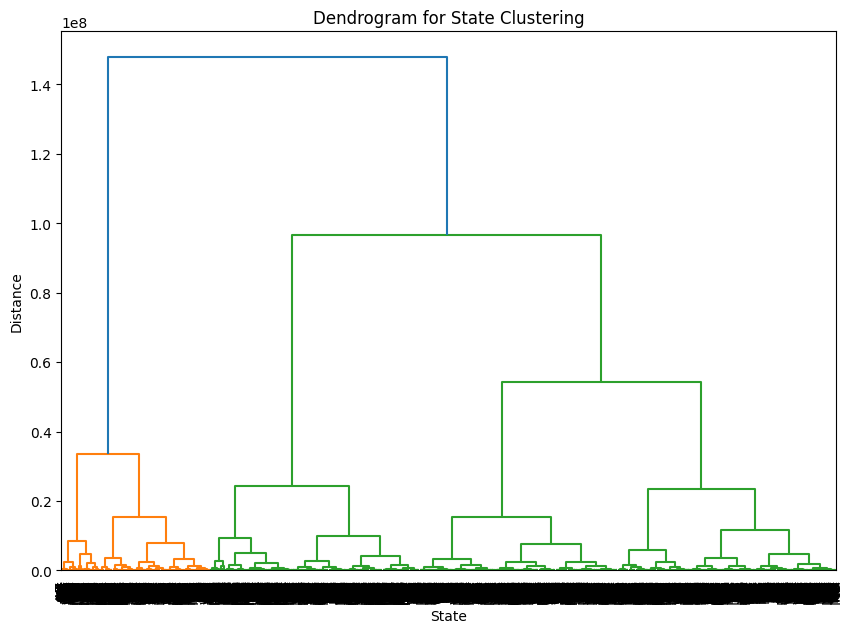

In [41]:
Z = linkage(new_df, method='ward')

# plotting the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(
    Z,
    labels=df['State Code'].values,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=None,
)
plt.title('Dendrogram for State Clustering')
plt.xlabel('State')
plt.ylabel('Distance')
plt.show()

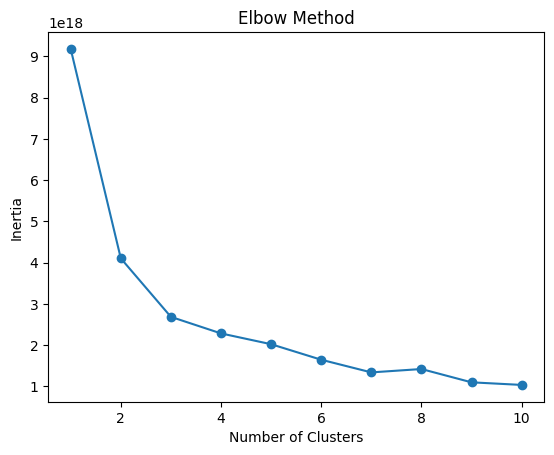

In [42]:
# Clustering the states
wcss = []

k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)


plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [43]:
encoder = LabelEncoder()

df['State Code Encoded'] = encoder.fit_transform(df['State Code'])


In [44]:
clusters = fcluster(Z, 4, criterion='maxclust')
cluster_states = {}

In [46]:
# Determining clusters and creating a composite risk score
num_clusters = 4
clusters = fcluster(Z, num_clusters, criterion='maxclust')
new_df['Cluster'] = clusters


/tmp/ipykernel_6112/2033782135.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cluster'] = clusters


In [47]:
# Aggregating additional variables for the composite risk score
selected_variables = ['Net Income from service to patients', 'Less Total Operating Expense', 'Allowable Bad Debts', 'Net Patient Revenue', 'Inpatient PPS Amount']
state_data_for_risk_score = df.groupby('State Code')[selected_variables].mean().reset_index()
state_data_for_risk_score

,State Code,Net Income from service to patients,Less Total Operating Expense,Allowable Bad Debts,Net Patient Revenue,Inpatient PPS Amount
0,AK,1.273436e+06,1.226648e+07,68041.333333,1.353992e+07,2.676564e+06
1,AL,5.377301e+05,9.759186e+06,21282.380282,1.029692e+07,1.405234e+06
2,AR,4.631784e+05,6.920360e+06,6386.339623,7.383538e+06,1.746079e+06
3,AZ,1.245762e+06,1.077977e+07,28955.886792,1.202553e+07,3.130530e+06
4,CA,1.061747e+06,1.054384e+07,16676.481840,1.160558e+07,4.578318e+06
5,CO,6.179862e+05,8.664916e+06,70495.135135,9.282902e+06,2.378647e+06
6,CT,6.324305e+05,1.179409e+07,13827.192308,1.242652e+07,2.758600e+06
7,DE,7.481162e+05,1.327490e+07,30598.916667,1.402302e+07,3.372424e+06
8,FL,5.494676e+05,1.059625e+07,389282.000000,1.114572e+07,3.510169e+06
9,GA,6.765997e+05,8.679422e+06,195254.544444,9.356021e+06,1.774254e+06


In [55]:
scaler = StandardScaler()
scaled_features_for_risk_score = scaler.fit_transform(state_data_for_risk_score[selected_variables])
performance = {}
for cluster_num in range(1, 5):
    states_in_cluster = new_df[new_df['Cluster'] == cluster_num]['State Code Encoded']
    cluster_data = state_data_for_risk_score[state_data_for_risk_score['State Code Encoded'].isin(states_in_cluster)]
    
    X = cluster_data[['Net Patient Revenue', 'Less Total Operating Expense', 'Allowable Bad Debts']]
    y = cluster_data['Revised Risk Score']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    models[f'Cluster {cluster_num}'] = model
    performance[f'Cluster {cluster_num}'] = {'MSE': mse, 'R-squared': r2}

print("MSE: ", mse)
print("R-squared: ", r2)

KeyError: 'State Code Encoded'

In [52]:
centroids = new_df.groupby('Cluster')[['Risk Score']].mean().reset_index()
closest_states = {}
for cluster_num in range(1, 5):
    centroid = centroids[centroids['Cluster'] == cluster_num].iloc[:, 1:].values
    cluster_data = new_df[new_df['Cluster'] == cluster_num][['Risk Score', 'ROI_Target', 'State Code Encoded']]
    
    distances = cdist(cluster_data, centroid, 'euclidean')
    closest_state_index = distances.argmin()
    closest_state = cluster_data.iloc[closest_state_index]
    
    closest_states[f'Cluster {cluster_num}'] = closest_state


centroids


ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)

In [53]:
# Ranking the states based on risk score
representative_states = ['MS', 'NY', 'MD', 'WA']
representative_states_risk_scores = state_data_for_risk_score[state_data_for_risk_score['State Code'].isin(representative_states)][['State Code', 'Revised Risk Score']]
representative_states_risk_scores

,State Code,Revised Risk Score
19,MD,-0.240286
24,MS,0.645115
33,NY,-0.555866
46,WA,0.062236
